# CNN Tabanlı Görüntü Sınıflandırma Projesi

**Adınız:** Eftalya Beril  
**Soyadınız:** ŞAHİN  
**Okul Numaranız:** 2212721037  
**GitHub Repo Bağlantısı:** https://github.com/EffieBerrie/CNN-Proje/blob/main/model1.ipynb

## Model 1 – VGG16 Tabanlı Derin Öğrenme Modeli

Bu modelde, **ImageNet veri seti üzerinde önceden eğitilmiş VGG16 mimarisi**
kullanılarak **transfer learning** yaklaşımı uygulanmıştır.
Amaç, çanta ve cüzdan sınıflarının görüntüler üzerinden ayırt edilmesidir.

### Veri Ön İşleme ve Veri Üreticileri

Modelde kullanılan görüntüler, VGG16 mimarisine uygun olacak şekilde
`preprocess_input` fonksiyonu ile normalize edilmiştir.

Veri seti üç ayrı klasöre ayrılmıştır:
- **Train:** Modelin öğrenmesi için
- **Validation:** Eğitim sırasında performans takibi için
- **Test:** Nihai performans değerlendirmesi için

Görüntüler `ImageDataGenerator` kullanılarak belirtilen dizinlerden
otomatik olarak yüklenmiştir.

### VGG16 Taban Model Yapısı

VGG16 modeli:
- ImageNet ağırlıkları ile yüklenmiştir
- Üst (fully connected) katmanlar çıkarılmıştır (`include_top=False`)
- Taban modelin tüm katmanları dondurulmuştur (`trainable=False`)

Bu sayede, önceden öğrenilmiş görsel özellikler korunarak
yalnızca yeni eklenen katmanlar eğitilmiştir.

### Eklenen Üst Katmanlar

VGG16 taban modelinin üzerine şu katmanlar eklenmiştir:
- Flatten katmanı
- 256 nöronlu ReLU aktivasyonlu Dense katmanı
- Overfitting’i azaltmak için Dropout (%30)
- Sınıf sayısı kadar nöron içeren Softmax çıkış katmanı

Bu yapı, transfer learning yaklaşımına uygun bir sınıflandırıcı oluşturur.

### Modelin Derlenmesi

Model:
- **Adam optimizasyon algoritması**
- **Categorical Crossentropy** kayıp fonksiyonu
- **Accuracy** metriği

kullanılarak derlenmiştir. Öğrenme oranı düşük tutulmuştur
(1e-4) çünkü önceden eğitilmiş bir model kullanılmaktadır.

### Eğitim Stratejisi ve Callback Kullanımı

Eğitim sürecinde:
- **EarlyStopping** ile validation loss iyileşmediğinde eğitim durdurulmuştur
- **ReduceLROnPlateau** ile validation loss sabitlendiğinde öğrenme oranı düşürülmüştür

Bu stratejiler, overfitting’i önlemek ve daha kararlı bir eğitim sağlamak amacıyla kullanılmıştır.

### Test ve Performans Değerlendirmesi

Eğitim tamamlandıktan sonra model,
daha önce hiç görmediği test verileri üzerinde değerlendirilmiştir.

Elde edilen test doğruluk oranı,
modelin çanta ve cüzdan sınıflarını ayırt etme başarısını göstermektedir.




In [2]:
# =======================
# MODEL 1 - VGG16 (ÇANTA / CÜZDAN)
# =======================

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------
# Hiperparametreler
# -----------------------
IMG_SIZE = 128
BATCH_SIZE = 24
EPOCHS = 15
DATA_DIR = "../dataset"

# -----------------------
# Veri Üreticileri
# -----------------------
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    directory=DATA_DIR + "/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    directory=DATA_DIR + "/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    directory=DATA_DIR + "/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = train_gen.num_classes

# -----------------------
# VGG16 Taban Model
# -----------------------
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

# -----------------------
# Üst Katmanlar
# -----------------------
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model1 = models.Model(inputs=base_model.input, outputs=outputs)

# -----------------------
# Derleme
# -----------------------
model1.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# -----------------------
# Callback'ler
# -----------------------
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        patience=2,
        factor=0.5
    )
]

# -----------------------
# Eğitim
# -----------------------
model1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

# -----------------------
# Test
# -----------------------
test_loss, test_acc = model1.evaluate(test_gen, verbose=0)
print("Model1 Test Accuracy (Çanta / Cüzdan):", test_acc)


Found 84 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6310 - loss: 4.2953 - val_accuracy: 0.8214 - val_loss: 3.4267 - learning_rate: 1.0000e-04
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8214 - loss: 1.3340 - val_accuracy: 0.8214 - val_loss: 3.9836 - learning_rate: 1.0000e-04
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9524 - loss: 0.4820 - val_accuracy: 0.8214 - val_loss: 3.0666 - learning_rate: 1.0000e-04
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9643 - loss: 0.2777 - val_accuracy: 0.8214 - val_loss: 2.8474 - learning_rate: 1.0000e-04
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9643 - loss: 0.1013 - val_accuracy: 0.8214 - val_loss: 3.1300 - learning_rate: 1.0000e-04
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9881 - loss: 0.0793 - val_accuracy: 0.8214 - val_loss: 3.2030 - 

MODEL 1 KATMAN TABLOSU


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,008,456 (80.14 MB)

 Trainable params: 2,097,922 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 4,195,846 (16.01 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Confusion Matrix:


,canta,cuzdan
canta,11,0
cuzdan,2,9



Classification Report:
              precision    recall  f1-score   support

       canta       0.85      1.00      0.92        11
      cuzdan       1.00      0.82      0.90        11

    accuracy                           0.91        22
   macro avg       0.92      0.91      0.91        22
weighted avg       0.92      0.91      0.91        22


Model 1 FINAL Test Accuracy: 0.9091


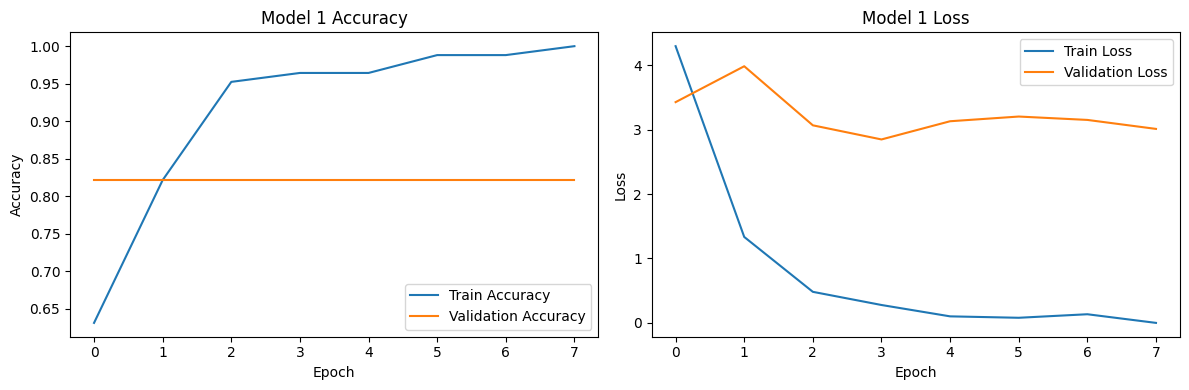

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ======================
# MODEL 1 – KATMAN TABLOSU
# ======================
print("MODEL 1 KATMAN TABLOSU")
model1.summary()

# ======================
# TEST TAHMİNLERİ
# ======================
predictions = model1.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# ======================
# CONFUSION MATRIX (TABLO)
# ======================
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

print("\nConfusion Matrix:")
display(cm_df)

# ======================
# CLASSIFICATION REPORT
# ======================
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

# ======================
# TEST ACCURACY
# ======================
test_loss, test_acc = model1.evaluate(test_gen, verbose=0)
print(f"\nModel 1 FINAL Test Accuracy: {test_acc:.4f}")

# ======================
# EĞİTİM GRAFİKLERİ
# ======================
history = model1.history.history

plt.figure(figsize=(12, 4))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(history["accuracy"], label="Train Accuracy")
plt.plot(history["val_accuracy"], label="Validation Accuracy")
plt.title("Model 1 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Model 1 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
